In [183]:
import numpy as np
import matplotlib.pyplot as plt
import math
import re
import itertools


In [316]:
#Coumpound counter start from 1
# Helper function for binary translation
def IntegerToBinaryTF(num: int, ls_bn: list)-> list:
    if num >= 2:
        ls_bn=IntegerToBinaryTF(num // 2, ls_bn)
    ls_bn.append(num % 2==1)
    return(ls_bn)


# Function to assigne each compound to its wells
def well_selecter(compound: int, n_wells:int, differentiate=1) -> np.array:
    if differentiate not in [1,2]:
        print('For the moment this code is only able to create well assignments matrices to distinguish up to combinations of 2 active compounds')
        return(-1)
    if differentiate==1:
        ls_bn=[]
        used_wells=IntegerToBinaryTF(compound, ls_bn)
        sel_wells=[False]*(n_wells-len(used_wells))+used_wells
    if differentiate==2:
        for i in range((n_wells-1)//3+1):
            if 0<compound and compound <= n_wells-1-3*i:
                sel_wells=(n_wells-1-3*i-compound)*[False]+[True]+i*3*[False]+[True]+[False]*(compound-1)
                break
            compound=compound-(n_wells-1-3*i)
    return(np.array(sel_wells))
    
def get_ncomp_from_nwells(nwells: int, differentiatie=1) ->int:
    if differentiatie==1:
        return(2**nwells-1)
    if differentiatie==2:
        temp_1=((nwells-2)//3)+1
        temp_2=temp_1-1
        return(nwells*temp_1-(temp_2*(temp_2+1)/2*3+temp_1)) #Some algebra gives this formula


# Function to be called by user to create the compound-wells assignment matrix
# This functions also identifies the minimum nuber of wells needed for the compunds and level of detail (differentiate) selected
def assing_wells_L(n_compounds:int, differentiate=1) -> np.array:

    if differentiate==1:
        n_wells=int(np.ceil(np.log2(n_samps +1)))
    if differentiate==2:
        tentative=int(np.floor(np.sqrt(6*n_compounds))) #empirical evidence suggest almost this scaling, mathematical proof mught arrive later
        for NW in [tentative-1,tentative,tentative+1]:
            if get_ncomp_from_nwells(NW, differentiatie=2)>=n_compounds:
                n_wells=NW
                break
        
    well_assigner=np.zeros((n_compounds, n_wells))==1
    for i in range(n_compounds):
        well_assigner[i,:]=well_selecter(i+1, n_wells, differentiate)
    return(well_assigner)

def assing_wells_mat(n_compounds:int)->np.array:
    L1=np.ceil(np.sqrt(n_compounds))
    L2=L1-1 if L1*(L1-1)>=n_compounds else L1
    well_assigner=np.zeros((n_compounds, int(L1+L2)))==1
    for i in range(n_compounds):
        cp_id=[int(i//L1), int(L1+i % L1)]
        well_assigner[i,cp_id]=True
    return(well_assigner)

# Hopeful implementation of the Shifted Transversal Design, what an acronym!

# From http://membres-timc.imag.fr/Nicolas.Thierry-Mieg/pdfs/ntm_IMA2012.pdf
# Corollary: If there are at most t positive variables and at most E false positive and E false negative observations: 
# STD(n;q;k) is a solution, when choosing q prime such that t⋅ Г(q,n)+2⋅ E  < q,  and  k = t⋅ Г+2⋅ E+1

def isprime(n):
    return re.compile(r'^1?$|^(11+)\1+$').match('1' * n) is None

def get_Gamma(q,N):
    return(int(np.ceil(np.log(N)/np.log(q))-1))

def get_s(N,j,q):
    vec=np.arange(N)
    out_vec=vec.copy()
    Gamma=get_Gamma(q,N)
    for ct in range(Gamma):
        c=ct+1
        out_vec=out_vec+j**c*(vec//q**c)
    return(out_vec)

def STD(N,q,k):
    L=np.zeros((k,q,N))==1
    for j in range(k):
        s=get_s(N,j,q)
        s=s%q
        idc=np.arange(N)
        L[j,s,idc]=True

    L=L.reshape(-1,N)
    return(L.T)

def assing_wells_STD(n_compounds:int, differentiate=1, False_results=0, force_q=False):
    N=n_compounds
    t=differentiate
    E=False_results
    poss_q=[x for x in range(n_compounds) if isprime(x)]
    for q in poss_q:
        if t*get_Gamma(q,N)+2*E<q:
            break
    if isprime(force_q):
        if t*get_Gamma(force_q,N)+2*E<force_q:
            q=force_q 
    Gamma=get_Gamma(q,N)
    k=t*Gamma+2*E+1
    WA=STD(N,q,k)
    return(WA)
 


# Helper function to actually implement the experiment
def from_well_get_compuonds(well:int, well_assigner: np.array)->np.array :
    return(np.array(np.where(well_assigner[:,well-1]))[0]+1)

def from_compound_get_wells(compound: int, well_assigner: np.array)-> np.array:
    return(np.array(np.where(well_assigner[compound-1,:]))[1]+1)

# Consistency check

def is_consistent_old(well_assigner:np.array, differentiate:int) -> list:
    n_comp=well_assigner.shape[0]
    if differentiate==1:
        full_well_assigner=well_assigner.copy()
    if differentiate==2:
        n_perms=int(n_comp*(n_comp-1)/2+n_comp)
        full_well_assigner=np.zeros((n_perms, well_assigner.shape[1]))==1
        full_well_assigner[-n_comp:,:]=well_assigner.copy()
        for i, j in enumerate(itertools.combinations(np.arange(well_assigner.shape[0]),2)):
            k,l=j
            full_well_assigner[i,:]=well_assigner[k,:]+well_assigner[l,:]
    if differentiate==3:
        n_perms=int(n_comp*(n_comp-1)*(n_comp-2)/6+n_comp*(n_comp-1)/2+n_comp)
        n3=int(n_comp*(n_comp-1)*(n_comp-2)/6)
        full_well_assigner=np.zeros((n_perms, well_assigner.shape[1]))==1
        full_well_assigner[-n_comp:,:]=well_assigner.copy()
        for i, j in enumerate(itertools.combinations(np.arange(well_assigner.shape[0]),3)):
            k,l,m=j
            full_well_assigner[i,:]=well_assigner[k,:]+well_assigner[l,:]+well_assigner[m,:]
        for i, j in enumerate(itertools.combinations(np.arange(well_assigner.shape[0]),2)):
            k,l=j
            full_well_assigner[i+n3,:]=well_assigner[k,:]+well_assigner[l,:]
    _, counts=np.unique(full_well_assigner, axis=0, return_counts=True)
    if np.unique(full_well_assigner, axis=0).shape[0]<full_well_assigner.shape[0]:
        return(False, full_well_assigner, counts)
    elif np.unique(full_well_assigner, axis=0).shape[0]==full_well_assigner.shape[0]:
        return(True,full_well_assigner, counts)
    else:
        return("Something is fishy")
    


def is_consistent(well_assigner:np.array, differentiate:int) -> list:
    N=well_assigner.shape[0]
    for i in range(differentiate):
        diff=i+1
        if diff ==1:
            full_well_assigner=well_assigner.copy()
        else:
            N_cmbn=math.comb(N,diff)
            temp_well_assigner=np.zeros((N_cmbn, well_assigner.shape[1]))==1
            for l,k in enumerate(itertools.combinations(np.arange(N),diff)):
                temp_well_assigner[l,:]=np.sum(well_assigner[k,:], axis=0).reshape(1,-1)
            full_well_assigner=np.concatenate((full_well_assigner,temp_well_assigner))
    _, counts=np.unique(full_well_assigner, axis=0, return_counts=True)
    if np.unique(full_well_assigner, axis=0).shape[0]<full_well_assigner.shape[0]:
        return(False, full_well_assigner, counts)
    elif np.unique(full_well_assigner, axis=0).shape[0]==full_well_assigner.shape[0]:
        return(True,full_well_assigner, counts)
    else:
        print("Something is fishy")
        return(-1)
    

def decode(well_assigner:np.ndarray, readout:np.ndarray, differentiate:int) -> list:
    N=well_assigner.shape[0]
    for i in range(differentiate):
        resulti=[]
        diff=i+1
        if diff ==1:
            resulti.extend(list(range(well_assigner.shape[0])))
            full_well_assigner=well_assigner.copy()
        else:
            N_cmbn=math.comb(N,diff)
            temp_well_assigner=np.zeros((N_cmbn, well_assigner.shape[1]))==1
            for l,k in enumerate(itertools.combinations(np.arange(N),diff)):
                resulti.append(k)
                temp_well_assigner[l,:]=np.sum(well_assigner[k,:], axis=0).reshape(1,-1)
            full_well_assigner=np.concatenate((full_well_assigner,temp_well_assigner))
    idxs=[i for i in range(full_well_assigner.shape[0]) if np.array_equal(full_well_assigner[i,:],readout)]
    if len(idxs)==0:
        print('No match')
        return(-1)
    
    return [resulti[i] for i in idxs]
        

    
    


In [39]:
# Select number of compuonds and make the well assigner
NC=120
WA=assing_wells_L(NC,differentiate=2)

In [4]:
#check shape for consitency
WA.shape

(120, 27)

In [52]:
#Print where a compound goes 
cp=np.random.randint(1,WA.shape[0]+1,1)
well_cp=from_compound_get_wells(cp,WA)
print('Compound', cp, 'needs to be in wells', well_cp)

Compound [2] needs to be in wells [25 26]


In [60]:
# Get all compounds for a well
wl=np.random.randint(1,WA.shape[1]+1,1)
cp_well=from_well_get_compuonds(wl,WA)
print('In well', wl, 'need to go compunds', cp_well)

In well [20] need to go compunds [  7   8  30  34  50  57  77  94 108 119]


In [ ]:
# Check answer ambiguity
tf, WAS, countss= is_consistent(WA, 2)

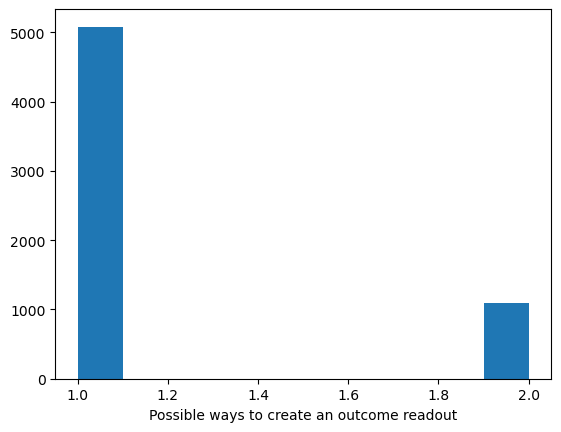

In [61]:
#Plot ambiguity
plt.hist(countss)
plt.xlabel('Possible ways to create an outcome readout')
plt.show()

In [29]:
pr1=np.sum(countss[countss>1])/np.sum(countss)
pr2=1-np.sum(countss[countss==1])/len(countss)
print('with this assignment method from',np.round(pr2*100) ,'to', np.round(pr1*100),'% of outcomes will lead to an ambiguous interpretation')

with this assignment method from 18.0 to 30.0 % of outcomes will lead to an ambiguous interpretation


Do the same for the matrix like well construction

In [30]:
WAM=assing_wells_mat(120)

In [31]:
WAM.shape

(120, 22)

In [32]:
tf, WAT, countsm= is_consistent(WAM, 2)

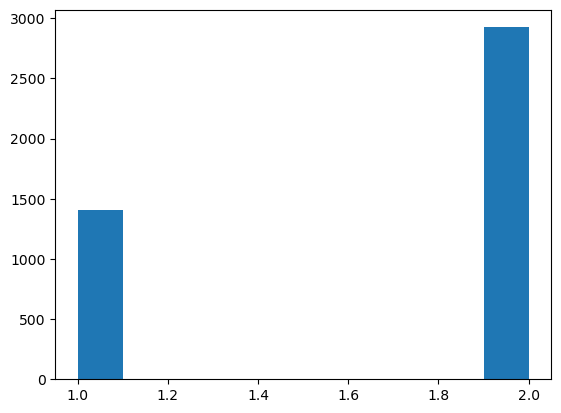

In [36]:
plt.hist(countsm)
plt.xlabel('Possible ways to create an outcome readout')
plt.show()

In [35]:
pr1=np.sum(countsm[countsm>1])/np.sum(countsm)
pr2=1-np.sum(countsm[countsm==1])/len(countsm)
print('with this assignment method from',np.round(pr2*100) ,'to', np.round(pr1*100),'% of outcomes will lead to an ambiguous interpretation')

with this assignment method from 67.0 to 81.0 % of outcomes will lead to an ambiguous interpretation


In [ ]:
cp=np.random.randint(1,WA.shape[0]+1,1)
well_cp=from_compound_get_wells(cp,WA)
print('Compound', cp, 'needs to be in wells', well_cp)

In [ ]:
wl=np.random.randint(1,WA.shape[1]+1,1)
cp_well=from_well_get_compuonds(wl,WA)
print('In well', wl, 'need to go compunds', cp_well)

In [131]:
WA=assing_wells_STD(n_compounds=120, differentiate=1)

In [132]:
WA.shape

(120, 15)

In [133]:
tf, WASTD, countstd= is_consistent(WA, 1)

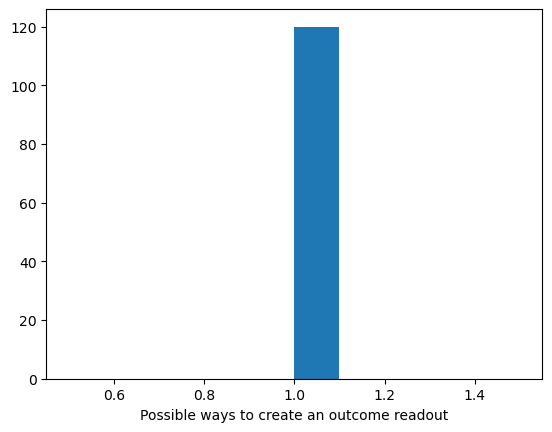

In [134]:
plt.hist(countstd)
plt.xlabel('Possible ways to create an outcome readout')
plt.show()

In [94]:
wl=np.random.randint(1,WA.shape[1]+1,1)
cp_well=from_well_get_compuonds(wl,WA)
print('In well', wl, 'need to go compunds', cp_well)

In well [2] need to go compunds [  2   7  12  17  22  27  32  37  42  47  52  57  62  67  72  77  82  87
  92  97 102 107 112 117]


In [326]:
# use the force_q argument to pass a known q, it will be used only if it satisfies the requirements
WA=assing_wells_STD(n_compounds=120, differentiate=1, force_q=11)

In [327]:
tf, WASTD, countstd= is_consistent(WA, 2)

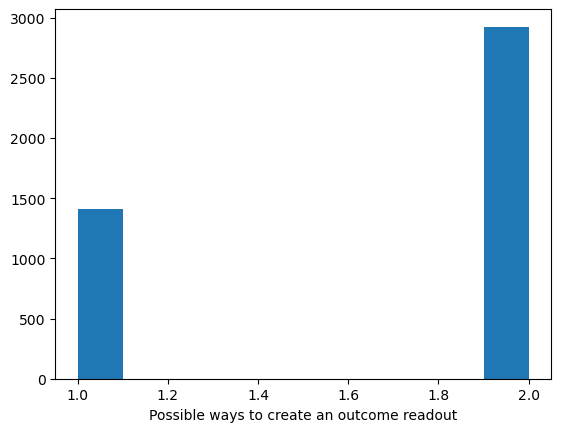

In [328]:
plt.hist(countstd)
plt.xlabel('Possible ways to create an outcome readout')
plt.show()

In [330]:
rw=np.random.randint(WASTD.shape[0])
res=WASTD[rw,:]#.reshape(1,-1)

decoded=decode(WA,res,2)

print('The possible compounds to be active are', decoded)

The possible compounds to be active are [(5, 67), (84, 117)]
